In [1]:
import pickle
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchtext
import dgl
import dgl.function as fn

import tqdm
import networkx as nx

import model
import layers
import sampler as sampler_module
import evaluation

Using backend: pytorch


## Data Loading
* MovieLens 데이터를 전처리한 pkl 파일


In [2]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data

{'train-graph': Graph(num_nodes={'movie': 3706, 'user': 6040},
       num_edges={('movie', 'watched-by', 'user'): 988129, ('user', 'watched', 'movie'): 988129},
       metagraph=[('movie', 'user', 'watched-by'), ('user', 'movie', 'watched')]),
 'val-matrix': <6040x3706 sparse matrix of type '<class 'numpy.int64'>'
 	with 6040 stored elements in COOrdinate format>,
 'test-matrix': <6040x3706 sparse matrix of type '<class 'numpy.int64'>'
 	with 6040 stored elements in COOrdinate format>,
 'item-texts': {'title': array(['Toy Story', 'Jumanji', 'Grumpier Old Men', ..., 'Tigerland',
         'Two Family House', 'Contender, The'], dtype=object)},
 'item-images': None,
 'user-type': 'user',
 'item-type': 'movie',
 'user-to-item-type': 'watched',
 'item-to-user-type': 'watched-by',
 'timestamp-edge-column': 'timestamp'}

In [4]:
graph = data['train-graph']
val_matrix = data['val-matrix'].tocsr()
test_matrix = data['test-matrix'].tocsr()
item_texts = data['item-texts']
user_ntype = data['user-type']
item_ntype = data['item-type']
user_to_item_etype = data['user-to-item-type']
timestamp = data['timestamp-edge-column']

# Assign user and movie IDs and use them as features (to learn an individual trainable
# embedding for each entity)
graph.nodes[user_ntype].data['id'] = torch.arange(graph.number_of_nodes(user_ntype))
graph.nodes[item_ntype].data['id'] = torch.arange(graph.number_of_nodes(item_ntype))

graph.nodes['movie']

NodeSpace(data={'year': tensor([75, 75, 75,  ..., 80, 80, 80]), 'genre': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'id': tensor([   0,    1,    2,  ..., 3703, 3704, 3705])})

#### Train data

In [5]:
graph.number_of_nodes()

9746

In [6]:
graph.has_edges_between(1, 3, 'watched')

False

In [7]:
graph.find_edges(1, 'watched')

(tensor([0]), tensor([639]))

In [8]:
graph.has_edges_between(0, 639, 'watched')

True

In [9]:
graph.edge_ids(0, 639, etype='watched')

1

In [10]:
graph.edge_subgraph({'watched':[1,639]})

Graph(num_nodes={'movie': 2, 'user': 2},
      num_edges={('movie', 'watched-by', 'user'): 0, ('user', 'watched', 'movie'): 2},
      metagraph=[('movie', 'user', 'watched-by'), ('user', 'movie', 'watched')])

In [11]:
edges = graph.all_edges(etype='watched')
edges

(tensor([   0,    0,    0,  ..., 6039, 6039, 6039]),
 tensor([1104,  639,  853,  ...,  548, 1024, 1025]))

#### Prepare torchtext dataset and vocabulary

* Torchtext Fields: 텍스트 처리 객체
* Torchtext Examples: 

In [12]:
fields = {}

for key, texts in data['item-texts'].items():
    fields[key] = torchtext.data.Field(include_lengths=True, lower=True, batch_first=True)
fields['title'].__dict__

{'sequential': True,
 'use_vocab': True,
 'init_token': None,
 'eos_token': None,
 'unk_token': '<unk>',
 'fix_length': None,
 'dtype': torch.int64,
 'preprocessing': None,
 'postprocessing': None,
 'lower': True,
 'tokenizer_args': (None, 'en'),
 'tokenize': <function torchtext.data.utils._split_tokenizer(x)>,
 'include_lengths': True,
 'batch_first': True,
 'pad_token': '<pad>',
 'pad_first': False,
 'truncate_first': False,
 'stop_words': None,
 'is_target': False}

In [13]:
examples = []

for movie_id in range(graph.number_of_nodes(data['item-type'])):
    field = [(key, fields[key]) for key in data['item-texts'].keys()]
    movie_list = [data['item-texts'][key][movie_id] for key in data['item-texts'].keys()]
    example = torchtext.data.Example.fromlist(movie_list, field)
    
    examples.append(example)
    
print(examples[0].__dict__)

{'title': ['toy', 'story']}


In [14]:
textset = torchtext.data.Dataset(examples, fields)
for key, field in fields.items():
    attr = getattr(textset, key)
    field.build_vocab(attr)

#### Hyper-Params

In [34]:
random_walk_length = 2
random_walk_restart_prob = .5
num_random_walks = 10
num_neighbors = 3
num_layers = 2
hidden_dims = 16
batch_size = 32
device = 'cpu'
num_epochs = 2
batches_per_epoch = 10000
num_workers = 0
lr = 3e-5
k = 10

#### Sampling & DataLoader

In [16]:
torch.arange(graph.number_of_nodes(item_ntype))

tensor([   0,    1,    2,  ..., 3703, 3704, 3705])

In [17]:
batch_sampler = sampler_module.ItemToItemBatchSampler(
    graph, user_ntype, item_ntype, batch_size)

neighbor_sampler = sampler_module.NeighborSampler(
    graph, user_ntype, item_ntype, random_walk_length,
    random_walk_restart_prob, num_random_walks, num_neighbors, num_layers)

collator = sampler_module.PinSAGECollator(neighbor_sampler, graph, item_ntype, textset)
dataloader = DataLoader(
    batch_sampler,
    collate_fn=collator.collate_train,
    num_workers=num_workers)
dataloader_test = DataLoader(
    torch.arange(graph.number_of_nodes(item_ntype)),
    batch_size=batch_size,
    collate_fn=collator.collate_test,
    num_workers=num_workers)
dataloader_it = iter(dataloader)

In [18]:
dataloader_test_it = iter(dataloader_test)

In [19]:
for block in dataloader_test_it.next():
    print(block.__dict__)


{'_graph': <dgl.heterograph_index.HeteroGraphIndex object at 0x000001E3E243F088>, '_canonical_etypes': [('movie', '_E', 'movie')], '_batch_num_nodes': None, '_batch_num_edges': None, '_ntypes': ['movie', 'movie'], '_srctypes_invmap': {'movie': 0}, '_dsttypes_invmap': {'movie': 1}, '_is_unibipartite': True, '_etypes': ['_E'], '_etype2canonical': {'_E': ('movie', '_E', 'movie')}, '_etypes_invmap': {('movie', '_E', 'movie'): 0}, '_node_frames': [{'_ID': tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,  107,  253,   46,  466,
         294,  488,  699,   68,  383,  649, 3029,  204,   63,  223, 1277,  113,
         164,  420,  444,  452,  339,  370,  507,  575,  580, 1017,  245,  471,
        1106,  313,  334,  305,  536,  679,   33,  143,  192,  145,  240,  358,
         763,  802, 1130, 1133,  343,  780, 1025,  593,  629,  22

In [20]:
def vis_graph(g):
    nx_G = g.to_networkx().to_undirected()
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

* Blocks: computation graph of each layers

In [21]:
pos_graph, neg_graph, blocks = dataloader_it.next()
pos_graph, neg_graph, blocks

(Graph(num_nodes=96, num_edges=32,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 Graph(num_nodes=96, num_edges=32,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 [Block(num_src_nodes=600, num_dst_nodes=307, num_edges=921),
  Block(num_src_nodes=307, num_dst_nodes=96, num_edges=288)])

* 배치 노드 95개 
* Pos Sample, Neg Sample 각각 추출
* Block은 층이라고 생각하면 쉬움
    * 95 -> 304 -> 604 

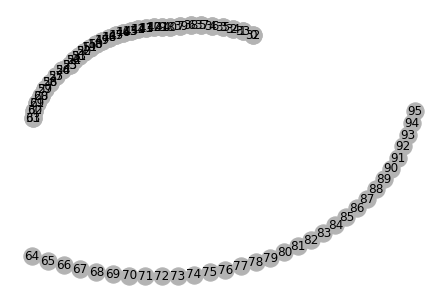

In [22]:
vis_graph(pos_graph)

In [23]:
pos_graph.all_edges()

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]))

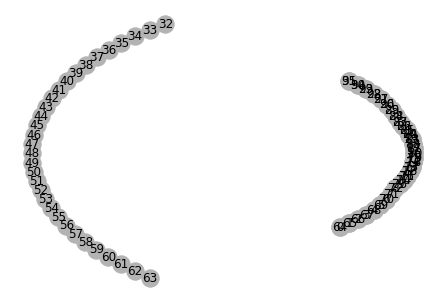

In [24]:
vis_graph(neg_graph)

In [25]:
neg_graph.all_edges()

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
         82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]))

#### Build Model
* PinSAGE
    * Field
        * proj: Projects each input feature of the graph linearly and sums them up
        * sage
        * scorer
    * Methods
        * forward
        * get_repr
    

In [26]:
graph

Graph(num_nodes={'movie': 3706, 'user': 6040},
      num_edges={('movie', 'watched-by', 'user'): 988129, ('user', 'watched', 'movie'): 988129},
      metagraph=[('movie', 'user', 'watched-by'), ('user', 'movie', 'watched')])

In [27]:
'''
Linear Projection
'''
from layers import _init_input_modules, BagOfWordsPretrained, BagOfWords

module_dict = _init_input_modules(graph, item_ntype, textset, hidden_dims)
print('임베딩 초기화')
print(module_dict)

def linear_proj(graph, ntype, textset, hidden_dims, ndata, module_dict):
        projections = []
        print('각 특성 별 임베딩')
        for feature, data in ndata.items():
            if feature == dgl.NID or feature.endswith('__len'):
                # This is an additional feature indicating the length of the ``feature``
                # column; we shouldn't process this.
                continue

            embeddings = module_dict[feature]  # return Moduledict
            print(embeddings)
            if isinstance(embeddings, (BagOfWords, BagOfWordsPretrained)):
                # Textual feature; find the length and pass it to the textual module.
                length = ndata[feature + '__len']
                result = embeddings(data, length)
            else:
                result = embeddings(data)
            projections.append(result)
        
        return projections, torch.stack(projections, 1).sum(1)

src_data = blocks[0].srcdata 
print('첫 임베딩에 필요한 노드 수', src_data['_ID'].shape, '\n')

proj, proj_result = linear_proj(graph, item_ntype, textset, hidden_dims, src_data, module_dict)
print('\n최종 임베딩')
[i.shape for i in proj], proj_result.shape

임베딩 초기화
ModuleDict(
  (year): Embedding(82, 16, padding_idx=81)
  (genre): Linear(in_features=18, out_features=16, bias=True)
  (id): Embedding(3707, 16, padding_idx=3706)
  (title): BagOfWords(
    (emb): Embedding(4946, 16, padding_idx=1)
  )
)
첫 임베딩에 필요한 노드 수 torch.Size([600]) 

각 특성 별 임베딩
Embedding(82, 16, padding_idx=81)
Linear(in_features=18, out_features=16, bias=True)
Embedding(3707, 16, padding_idx=3706)
BagOfWords(
  (emb): Embedding(4946, 16, padding_idx=1)
)

최종 임베딩


([torch.Size([600, 16]),
  torch.Size([600, 16]),
  torch.Size([600, 16]),
  torch.Size([600, 16])],
 torch.Size([600, 16]))

In [28]:
proj_result

tensor([[ 0.4361,  0.1865, -0.4382,  ...,  0.1614,  0.3474,  0.4206],
        [-0.5864, -0.1675, -0.0165,  ..., -0.3198,  0.1590, -0.1004],
        [ 0.2178,  0.1362, -0.4510,  ...,  0.0075, -0.0219,  0.2457],
        ...,
        [ 0.0078,  0.1650, -0.2061,  ...,  0.4054,  0.1358,  0.4498],
        [-0.4182,  0.1809,  0.3471,  ...,  0.0552,  0.2536,  0.3946],
        [ 0.1511,  0.4827, -0.1880,  ...,  0.2587,  0.0916,  0.6906]],
       grad_fn=<SumBackward1>)

In [29]:
class PinSAGEModel(nn.Module):
    def __init__(self, full_graph, ntype, textsets, hidden_dims, n_layers):
        super().__init__()

        self.proj = layers.LinearProjector(full_graph, ntype, textsets, hidden_dims)
        self.sage = layers.SAGENet(hidden_dims, n_layers)
        self.scorer = layers.ItemToItemScorer(full_graph, ntype)

    def forward(self, pos_graph, neg_graph, blocks):
        h_item = self.get_repr(blocks)
        pos_score = self.scorer(pos_graph, h_item)
        neg_score = self.scorer(neg_graph, h_item)
        
        # Lower the better
        # clamp min = 0 -> max(score, 0)
        # neg score down, pos socre up
        return (neg_score - pos_score + 1).clamp(min=0)
    
    def get_repr(self, blocks):
        h_item = self.proj(blocks[0].srcdata)
        h_item_dst = self.proj(blocks[-1].dstdata)
        return h_item_dst + self.sage(blocks, h_item)
    
    
model = PinSAGEModel(graph, item_ntype, textset, hidden_dims, num_layers).to(device)

In [30]:
batch_graph = model.get_repr(blocks)
batch_graph.shape

torch.Size([96, 16])

In [31]:
pos_graph

Graph(num_nodes=96, num_edges=32,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

#### Loss

```
def forward(self, item_item_graph, h):
    """
    item_item_graph : graph consists of edges connecting the pairs
    h : hidden state of every node
    """
    with item_item_graph.local_scope():
        item_item_graph.ndata['h'] = h            
        item_item_graph.apply_edges(fn.u_dot_v('h', 'h', 's'))
        item_item_graph.apply_edges(self._add_bias)
        pair_score = item_item_graph.edata['s']

    return pair_score
```

In [32]:
scorer = layers.ItemToItemScorer(graph, item_ntype)
pos_score = scorer(pos_graph, batch_graph)
neg_score = scorer(neg_graph, batch_graph)
print(pos_score)
print(neg_score)

score = (neg_score - pos_score + 1).clamp(min=0)
score

tensor([[ 0.0528,  0.0528,  0.0528,  ...,  0.0528,  0.0528,  0.0528],
        [ 0.7408,  0.7408,  0.7408,  ...,  0.7408,  0.7408,  0.7408],
        [ 2.0894,  2.0894,  2.0894,  ...,  2.0894,  2.0894,  2.0894],
        ...,
        [ 0.4675,  0.4675,  0.4675,  ...,  0.4675,  0.4675,  0.4675],
        [-0.2839, -0.2839, -0.2839,  ..., -0.2839, -0.2839, -0.2839],
        [ 1.7166,  1.7166,  1.7166,  ...,  1.7166,  1.7166,  1.7166]],
       grad_fn=<AddBackward0>)
tensor([[ 0.4412,  0.4412,  0.4412,  ...,  0.4412,  0.4412,  0.4412],
        [ 1.6502,  1.6502,  1.6502,  ...,  1.6502,  1.6502,  1.6502],
        [ 1.6965,  1.6965,  1.6965,  ...,  1.6965,  1.6965,  1.6965],
        ...,
        [-0.7755, -0.7755, -0.7755,  ..., -0.7755, -0.7755, -0.7755],
        [ 0.4158,  0.4158,  0.4158,  ...,  0.4158,  0.4158,  0.4158],
        [ 0.8470,  0.8470,  0.8470,  ...,  0.8470,  0.8470,  0.8470]],
       grad_fn=<AddBackward0>)


tensor([[1.3883, 1.3883, 1.3883,  ..., 1.3883, 1.3883, 1.3883],
        [1.9094, 1.9094, 1.9094,  ..., 1.9094, 1.9094, 1.9094],
        [0.6071, 0.6071, 0.6071,  ..., 0.6071, 0.6071, 0.6071],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.6997, 1.6997, 1.6997,  ..., 1.6997, 1.6997, 1.6997],
        [0.1304, 0.1304, 0.1304,  ..., 0.1304, 0.1304, 0.1304]],
       grad_fn=<ClampBackward>)

In [33]:
score.mean()

tensor(0.8710, grad_fn=<MeanBackward0>)

#### Training

In [ ]:
# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr)

# For each batch of head-tail-negative triplets...
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm.trange(batches_per_epoch):
        pos_graph, neg_graph, blocks = next(dataloader_it)
        # Copy to GPU
        for i in range(len(blocks)):
            blocks[i] = blocks[i].to(device)
        pos_graph = pos_graph.to(device)
        neg_graph = neg_graph.to(device)

        loss = model(pos_graph, neg_graph, blocks).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()

    # Evaluate
#     model.eval()
#     with torch.no_grad():
#         item_batches = torch.arange(g.number_of_nodes(item_ntype)).split(args.batch_size)
#         h_item_batches = []
#         for blocks in dataloader_test:
#             for i in range(len(blocks)):
#                 blocks[i] = blocks[i].to(device)

#             h_item_batches.append(model.get_repr(blocks))
#         h_item = torch.cat(h_item_batches, 0)

#         print(evaluation.evaluate_nn(dataset, h_item, args.k, args.batch_size))


 97%|████████████████████████████████████████████████████████████████████████▍  | 9665/10000 [1:28:13<00:35,  9.57it/s]

In [ ]:
torch.save(model, 'model.pt')

#### Eval

In [61]:
iter(dataloader_test).next()

[Block(num_src_nodes=295, num_dst_nodes=112, num_edges=336),
 Block(num_src_nodes=112, num_dst_nodes=32, num_edges=96)]

In [102]:
model.eval()
with torch.no_grad():
    # total Node# // batch size -> item batch length    
    h_item_batches = []
    for eval_blocks in dataloader_test:
        for i in range(len(eval_blocks)):
            eval_blocks[i] = eval_blocks[i].to(device)

        h_item_batches.append(model.get_repr(eval_blocks))
#     print([len(i) for i in h_item_batches])
    h_item = torch.cat(h_item_batches, 0)
h_item
#     print(h_item.shape)

tensor([[ 0.2101,  0.7534,  0.5296,  ..., -0.2043,  0.2532,  0.2499],
        [ 0.1885,  0.4020,  0.8579,  ..., -0.2344, -0.1502,  0.6469],
        [ 0.2375,  0.7160,  0.7158,  ..., -0.2603,  0.4337,  0.0484],
        ...,
        [ 0.0139,  0.1266,  0.3120,  ..., -0.2165,  0.3812,  0.0498],
        [ 0.1473, -0.1549,  0.5258,  ..., -0.2109,  0.3043,  0.1404],
        [ 0.3737,  0.3927,  0.1712,  ..., -0.4620, -0.0108, -0.2153]])

In [103]:
h_item.shape

torch.Size([3706, 16])

In [80]:
rec_engine = evaluation.LatestNNRecommender(
    user_ntype, item_ntype, user_to_item_etype, timestamp, batch_size)
recommendations = rec_engine.recommend(graph, k, None, h_item).cpu().numpy()
recommendations

array([[1935, 1864,  284, ..., 1900, 3457, 3589],
       [2494,  573, 2401, ..., 1432, 2597, 1366],
       [1130,  574, 2738, ..., 2586, 3044, 1900],
       ...,
       [2967,  578, 1195, ..., 1822, 2704,  336],
       [1745,  151,  722, ...,  459,  502,  346],
       [1445, 2494, 1115, ..., 1223, 3294, 2708]], dtype=int64)

#### Validation data

In [53]:
print(f'{data["val-matrix"]}')

  (0, 1439)	1
  (1, 1420)	1
  (2, 101)	1
  (3, 2743)	1
  (4, 1371)	1
  (5, 1441)	1
  (6, 1575)	1
  (7, 704)	1
  (8, 2102)	1
  (9, 2489)	1
  (10, 1895)	1
  (11, 1160)	1
  (12, 1873)	1
  (13, 2526)	1
  (14, 3512)	1
  (15, 2496)	1
  (16, 1470)	1
  (17, 259)	1
  (18, 309)	1
  (19, 1148)	1
  (20, 582)	1
  (21, 847)	1
  (22, 1938)	1
  (23, 1779)	1
  (24, 3503)	1
  :	:
  (6015, 3520)	1
  (6016, 2699)	1
  (6017, 532)	1
  (6018, 784)	1
  (6019, 2708)	1
  (6020, 1696)	1
  (6021, 466)	1
  (6022, 724)	1
  (6023, 1927)	1
  (6024, 525)	1
  (6025, 513)	1
  (6026, 1398)	1
  (6027, 2773)	1
  (6028, 2624)	1
  (6029, 651)	1
  (6030, 354)	1
  (6031, 1906)	1
  (6032, 283)	1
  (6033, 881)	1
  (6034, 1583)	1
  (6035, 2602)	1
  (6036, 907)	1
  (6037, 2495)	1
  (6038, 861)	1
  (6039, 155)	1


In [134]:
val_mat = data["val-matrix"].toarray()

In [107]:
titles = data['item-texts']['title']
titles

array(['Toy Story', 'Jumanji', 'Grumpier Old Men', ..., 'Tigerland',
       'Two Family House', 'Contender, The'], dtype=object)

In [147]:
def rec_eval(matrix, src, dst):
    src = matrix[src]
    print('\n주어진 노드:', src)
    for idx, d in enumerate(dst):
        print(f'\t추천 {idx}: {matrix[d]}')
    
for idx, rec in enumerate(recommendations):
    rec_eval(titles, idx, rec)


주어진 노드: Toy Story
	추천 0: Lord of the Rings, The
	추천 1: Far Off Place, A
	추천 2: Professional, The (a.k.a. Leon: The Professional)
	추천 3: Quest for Camelot
	추천 4: Dreamscape
	추천 5: Kid in King Arthur's Court, A
	추천 6: Things to Do in Denver when You're Dead
	추천 7: Little Mermaid, The
	추천 8: Starman
	추천 9: Bronco Billy

주어진 노드: Jumanji
	추천 0: Arachnophobia
	추천 1: Ghost
	추천 2: eXistenZ
	추천 3: Face/Off
	추천 4: Predator
	추천 5: Tomorrow Never Dies
	추천 6: Jumpin' Jack Flash
	추천 7: Speed 2: Cruise Control
	추천 8: Tequila Sunrise
	추천 9: Saint, The

주어진 노드: Grumpier Old Men
	추천 0: Blues Brothers, The
	추천 1: Aladdin
	추천 2: Help!
	추천 3: Popeye
	추천 4: Batman Returns
	추천 5: Great Race, The
	추천 6: Grease
	추천 7: Airplane!
	추천 8: Stop! Or My Mom Will Shoot
	추천 9: Little Mermaid, The

주어진 노드: Waiting to Exhale
	추천 0: Arachnophobia
	추천 1: eXistenZ
	추천 2: Blues Brothers, The
	추천 3: Aliens
	추천 4: Ghost
	추천 5: Jumpin' Jack Flash
	추천 6: Face/Off
	추천 7: Rent-A-Cop
	추천 8: Speed
	추천 9: Payback

주어진 노드: Father of 

주어진 노드: Free Willy 2: The Adventure Home
	추천 0: Little Mermaid, The
	추천 1: Aladdin
	추천 2: Lady and the Tramp
	추천 3: Kid in King Arthur's Court, A
	추천 4: Nightmare Before Christmas, The
	추천 5: Pollyanna
	추천 6: Babe
	추천 7: Mary Poppins
	추천 8: Jungle Book, The
	추천 9: Herbie Goes Bananas

주어진 노드: Hackers
	추천 0: Little Mermaid, The
	추천 1: Hercules
	추천 2: Aladdin
	추천 3: Lady and the Tramp
	추천 4: Pocahontas
	추천 5: Steamboat Willie
	추천 6: Arachnophobia
	추천 7: Grease
	추천 8: Mary Poppins
	추천 9: Popeye

주어진 노드: Jeffrey
	추천 0: Truth or Consequences, N.M.
	추천 1: Out of Sight
	추천 2: Dreamscape
	추천 3: Goodbye, Lover
	추천 4: F/X
	추천 5: Atlantic City
	추천 6: Conspiracy Theory
	추천 7: Moonraker
	추천 8: Free Enterprise
	추천 9: Ronin

주어진 노드: Johnny Mnemonic
	추천 0: Little Mermaid, The
	추천 1: Lady and the Tramp
	추천 2: Hercules
	추천 3: Grease
	추천 4: Aladdin
	추천 5: Jumpin' Jack Flash
	추천 6: Steamboat Willie
	추천 7: True Lies
	추천 8: Prizzi's Honor
	추천 9: Goodbye, Lover

주어진 노드: Judge Dredd
	추천 0: Little Mermaid, The


주어진 노드: Three Colors: Red
	추천 0: Alligator
	추천 1: Alien: Resurrection
	추천 2: Chopping Mall (a.k.a. Killbots)
	추천 3: Blob, The
	추천 4: Alien³
	추천 5: Fly, The
	추천 6: Hidden, The
	추천 7: Plan 9 from Outer Space
	추천 8: Deep Rising
	추천 9: Wild Wild West

주어진 노드: Three Colors: Blue
	추천 0: Montana
	추천 1: Glory
	추천 2: Knightriders
	추천 3: Ben-Hur
	추천 4: Longest Day, The
	추천 5: Babyfever
	추천 6: This Is Spinal Tap
	추천 7: Renaissance Man
	추천 8: Lethal Weapon
	추천 9: Jack

주어진 노드: Three Colors: White
	추천 0: Blues Brothers, The
	추천 1: Arachnophobia
	추천 2: Aladdin
	추천 3: Mystery Men
	추천 4: Tank Girl
	추천 5: Freejack
	추천 6: Rent-A-Cop
	추천 7: Stop! Or My Mom Will Shoot
	추천 8: Twin Dragons (Shuang long hui)
	추천 9: Careful

주어진 노드: Red Firecracker, Green Firecracker
	추천 0: Popeye
	추천 1: Little Mermaid, The
	추천 2: Babyfever
	추천 3: Grease
	추천 4: Help!
	추천 5: Mary Poppins
	추천 6: Speechless
	추천 7: Hercules
	추천 8: This Is Spinal Tap
	추천 9: Faust

주어진 노드: Rent-a-Kid
	추천 0: Popeye
	추천 1: Montana
	추천 2: Blues Broth

	추천 7: Hercules
	추천 8: Lady and the Tramp
	추천 9: Batman Returns

주어진 노드: Jimmy Hollywood
	추천 0: Montana
	추천 1: Popeye
	추천 2: This Is Spinal Tap
	추천 3: Blues Brothers, The
	추천 4: Simpatico
	추천 5: Lethal Weapon 3
	추천 6: Babyfever
	추천 7: Man Bites Dog (C'est arrivé près de chez vous)
	추천 8: Molly
	추천 9: Muppet Treasure Island

주어진 노드: Judgment Night
	추천 0: Arachnophobia
	추천 1: Speed
	추천 2: Ghost
	추천 3: Aliens
	추천 4: True Lies
	추천 5: Moonraker
	추천 6: African Queen, The
	추천 7: Maverick
	추천 8: Jumpin' Jack Flash
	추천 9: Rent-A-Cop

주어진 노드: Jurassic Park
	추천 0: Babyfever
	추천 1: Montana
	추천 2: This Is Spinal Tap
	추천 3: Popeye
	추천 4: What Happened Was...
	추천 5: Corrina, Corrina
	추천 6: Aladdin
	추천 7: Simpatico
	추천 8: Babe
	추천 9: Sirens

주어진 노드: Kalifornia
	추천 0: Montana
	추천 1: Babyfever
	추천 2: Batman
	추천 3: Renaissance Man
	추천 4: This Is Spinal Tap
	추천 5: Knightriders
	추천 6: Jack
	추천 7: Ben-Hur
	추천 8: Striptease
	추천 9: Glory

주어진 노드: Killing Zoe
	추천 0: Montana
	추천 1: Batman
	추천 2: This Is Spinal 

	추천 9: Wizard of Oz, The

주어진 노드: It's My Party
	추천 0: eXistenZ
	추천 1: Ghost
	추천 2: Predator
	추천 3: Notorious
	추천 4: Transformers: The Movie, The
	추천 5: Matrix, The
	추천 6: Deep Blue Sea
	추천 7: Saint, The
	추천 8: Tequila Sunrise
	추천 9: Little Mermaid, The

주어진 노드: Country Life
	추천 0: Montana
	추천 1: Twilight
	추천 2: Batman
	추천 3: Croupier
	추천 4: Atlantic City
	추천 5: Rounders
	추천 6: Belly
	추천 7: Bound
	추천 8: Bat Whispers, The
	추천 9: Cyclo

주어진 노드: Operation Dumbo Drop
	추천 0: eXistenZ
	추천 1: Conquest of the Planet of the Apes
	추천 2: Westworld
	추천 3: Universal Soldier: The Return
	추천 4: Wing Commander
	추천 5: Moonraker
	추천 6: Godzilla 2000 (Gojira ni-sen mireniamu)
	추천 7: Deep Blue Sea
	추천 8: Freejack
	추천 9: Godzilla

주어진 노드: Promise, The (Versprechen, Das)
	추천 0: Alligator
	추천 1: Aliens
	추천 2: Freejack
	추천 3: Chopping Mall (a.k.a. Killbots)
	추천 4: Deep Rising
	추천 5: Timecop
	추천 6: Wisdom
	추천 7: Alien
	추천 8: Army of Darkness
	추천 9: Braindead

주어진 노드: Mrs. Winterbourne
	추천 0: Bound
	추천 1: Monta

	추천 2: This Is Spinal Tap
	추천 3: Babyfever
	추천 4: Blues Brothers, The
	추천 5: Simpatico
	추천 6: Help!
	추천 7: Grease
	추천 8: Muppet Treasure Island
	추천 9: Lethal Weapon 3

주어진 노드: Small Faces
	추천 0: Lady and the Tramp
	추천 1: Help!
	추천 2: Blues Brothers, The
	추천 3: Little Mermaid, The
	추천 4: Aladdin
	추천 5: Steamboat Willie
	추천 6: Great Race, The
	추천 7: Popeye
	추천 8: Hercules
	추천 9: Damsel in Distress, A

주어진 노드: Bound
	추천 0: Bound
	추천 1: Montana
	추천 2: Batman
	추천 3: This Is Spinal Tap
	추천 4: Mystery Train
	추천 5: Professional, The (a.k.a. Leon: The Professional)
	추천 6: Lethal Weapon
	추천 7: Lethal Weapon 4
	추천 8: Hana-bi
	추천 9: Emma

주어진 노드: Carpool
	추천 0: eXistenZ
	추천 1: Westworld
	추천 2: Moonraker
	추천 3: Alligator
	추천 4: Alien³
	추천 5: Freejack
	추천 6: Matrix, The
	추천 7: Face/Off
	추천 8: Conquest of the Planet of the Apes
	추천 9: Aliens

주어진 노드: Death in Brunswick
	추천 0: Montana
	추천 1: Batman
	추천 2: Simpatico
	추천 3: Wizard of Oz, The
	추천 4: Limey, The
	추천 5: Popeye
	추천 6: Lethal Weapon 4
	추천 7: 

	추천 0: eXistenZ
	추천 1: Notorious
	추천 2: Truth or Consequences, N.M.
	추천 3: Stag
	추천 4: Rebecca
	추천 5: Moonraker
	추천 6: Charade
	추천 7: Fever Pitch
	추천 8: Murphy's Romance
	추천 9: Big One, The

주어진 노드: Sound of Music, The
	추천 0: Inspector Gadget
	추천 1: Aladdin
	추천 2: Condorman
	추천 3: Ben-Hur
	추천 4: Pocahontas
	추천 5: Mystery Men
	추천 6: Knightriders
	추천 7: Hercules
	추천 8: Fled
	추천 9: Popeye

주어진 노드: Die Hard
	추천 0: Aladdin
	추천 1: Little Mermaid, The
	추천 2: Lady and the Tramp
	추천 3: Popeye
	추천 4: Hercules
	추천 5: Batman Returns
	추천 6: Jungle Book, The
	추천 7: Batman Forever
	추천 8: Help!
	추천 9: Herbie Goes Bananas

주어진 노드: Lawnmower Man, The
	추천 0: True Lies
	추천 1: Twister
	추천 2: Romancing the Stone
	추천 3: Ghost
	추천 4: Jewel of the Nile, The
	추천 5: Mystery Men
	추천 6: Pocahontas
	추천 7: Inspector Gadget
	추천 8: Moonraker
	추천 9: Speed

주어진 노드: Unhook the Stars
	추천 0: Aladdin
	추천 1: Grease
	추천 2: Blues Brothers, The
	추천 3: Help!
	추천 4: Montana
	추천 5: Little Mermaid, The
	추천 6: Hercules
	추천 7: Pal Jo

	추천 2: Bound
	추천 3: Hana-bi
	추천 4: Best Men
	추천 5: Twilight
	추천 6: Wild Things
	추천 7: Limey, The
	추천 8: Midnight in the Garden of Good and Evil
	추천 9: Cop Land

주어진 노드: Star Wars: Episode VI - Return of the Jedi
	추천 0: This Is Spinal Tap
	추천 1: Montana
	추천 2: Popeye
	추천 3: Best Men
	추천 4: Aladdin
	추천 5: Help!
	추천 6: Lethal Weapon
	추천 7: Man Bites Dog (C'est arrivé près de chez vous)
	추천 8: Babyfever
	추천 9: Lethal Weapon 2

주어진 노드: Wings of Desire (Der Himmel über Berlin)
	추천 0: eXistenZ
	추천 1: Deep Blue Sea
	추천 2: Moonraker
	추천 3: Tank Girl
	추천 4: Jumpin' Jack Flash
	추천 5: Men in Black
	추천 6: Spawn
	추천 7: Predator 2
	추천 8: Conquest of the Planet of the Apes
	추천 9: Wild Wild West

주어진 노드: Third Man, The
	추천 0: Wild Wild West
	추천 1: Quick and the Dead, The
	추천 2: Tashunga
	추천 3: True Grit
	추천 4: Dancemaker
	추천 5: Titan A.E.
	추천 6: High Noon
	추천 7: Wild Man Blues
	추천 8: 42 Up
	추천 9: Hoop Dreams

주어진 노드: GoodFellas
	추천 0: Aladdin
	추천 1: Blues Brothers, The
	추천 2: Little Mermaid, The
	추천 3:

	추천 5: Goodbye, Lover
	추천 6: Lethal Weapon 3
	추천 7: Montana
	추천 8: Batman Returns
	추천 9: Carpool

주어진 노드: Jaws 3-D
	추천 0: Aladdin
	추천 1: Popeye
	추천 2: Montana
	추천 3: Lethal Weapon
	추천 4: Mary Poppins
	추천 5: Help!
	추천 6: Pollyanna
	추천 7: Hercules
	추천 8: Little Mermaid, The
	추천 9: Nightmare Before Christmas, The

주어진 노드: My Fellow Americans
	추천 0: Montana
	추천 1: Batman
	추천 2: Simpatico
	추천 3: Limey, The
	추천 4: Popeye
	추천 5: Lethal Weapon 4
	추천 6: Wizard of Oz, The
	추천 7: Lethal Weapon 3
	추천 8: Ben-Hur
	추천 9: This Is Spinal Tap

주어진 노드: Mars Attacks!
	추천 0: Blues Brothers, The
	추천 1: Popeye
	추천 2: This Is Spinal Tap
	추천 3: Montana
	추천 4: Lethal Weapon 3
	추천 5: Babyfever
	추천 6: Man Bites Dog (C'est arrivé près de chez vous)
	추천 7: Batman Returns
	추천 8: Lethal Weapon 2
	추천 9: Simpatico

주어진 노드: Citizen Ruth
	추천 0: Mystery Men
	추천 1: Blues Brothers, The
	추천 2: Inspector Gadget
	추천 3: Montana
	추천 4: Popeye
	추천 5: Batman Returns
	추천 6: Moonraker
	추천 7: Ben-Hur
	추천 8: Timecop
	추천 9: Simpatico



	추천 1: Hana-bi
	추천 2: Atlantic City
	추천 3: Professional, The (a.k.a. Leon: The Professional)
	추천 4: Little Mermaid, The
	추천 5: Goodbye, Lover
	추천 6: Dog Day Afternoon
	추천 7: Nightmare Before Christmas, The
	추천 8: Lethal Weapon 4
	추천 9: Sneakers

주어진 노드: G.I. Jane
	추천 0: Arachnophobia
	추천 1: eXistenZ
	추천 2: Blues Brothers, The
	추천 3: Aliens
	추천 4: Ghost
	추천 5: Jumpin' Jack Flash
	추천 6: Face/Off
	추천 7: Rent-A-Cop
	추천 8: Speed
	추천 9: Predator

주어진 노드: Conan the Barbarian
	추천 0: Arachnophobia
	추천 1: eXistenZ
	추천 2: Predator
	추천 3: Event Horizon
	추천 4: Predator 2
	추천 5: Moonraker
	추천 6: Matrix, The
	추천 7: Ghost
	추천 8: Deep Blue Sea
	추천 9: Westworld

주어진 노드: George of the Jungle
	추천 0: Lady and the Tramp
	추천 1: Kid in King Arthur's Court, A
	추천 2: Pollyanna
	추천 3: Mary Poppins
	추천 4: Herbie Goes Bananas
	추천 5: Herbie Rides Again
	추천 6: Hercules
	추천 7: Goofy Movie, A
	추천 8: Muppet Treasure Island
	추천 9: Heavyweights

주어진 노드: Cop Land
	추천 0: Montana
	추천 1: This Is Spinal Tap
	추천 2: Popeye
	추천 

	추천 9: Invasion of the Body Snatchers

주어진 노드: Suicide Kings
	추천 0: Blues Brothers, The
	추천 1: Aladdin
	추천 2: Popeye
	추천 3: Help!
	추천 4: Grease
	추천 5: Tank Girl
	추천 6: Blues Brothers 2000
	추천 7: Lady and the Tramp
	추천 8: Man Bites Dog (C'est arrivé près de chez vous)
	추천 9: Grease 2

주어진 노드: Man in the Iron Mask, The
	추천 0: Montana
	추천 1: Mystery Train
	추천 2: Man Bites Dog (C'est arrivé près de chez vous)
	추천 3: Best Men
	추천 4: Goodbye, Lover
	추천 5: Hana-bi
	추천 6: Popeye
	추천 7: Batman Returns
	추천 8: Striptease
	추천 9: Grease

주어진 노드: Newton Boys, The
	추천 0: Honey, I Shrunk the Kids
	추천 1: Rocky Horror Picture Show, The
	추천 2: Crimson Pirate, The
	추천 3: Lord of the Rings, The
	추천 4: Cat from Outer Space, The
	추천 5: Night of the Creeps
	추천 6: Piranha
	추천 7: Children of the Damned
	추천 8: 20,000 Leagues Under the Sea
	추천 9: Titan A.E.

주어진 노드: Wild Things
	추천 0: Montana
	추천 1: Batman
	추천 2: Kim
	추천 3: Ben-Hur
	추천 4: Babyfever
	추천 5: This Is Spinal Tap
	추천 6: Simpatico
	추천 7: Knightriders
	추

	추천 6: Ben-Hur
	추천 7: Longest Day, The
	추천 8: Iron Eagle
	추천 9: Rent-A-Cop

주어진 노드: Lethal Weapon
	추천 0: Notorious
	추천 1: Speed 2: Cruise Control
	추천 2: Saint, The
	추천 3: Tomorrow Never Dies
	추천 4: Predator
	추천 5: Strangers on a Train
	추천 6: Life Less Ordinary, A
	추천 7: Dark City
	추천 8: Face/Off
	추천 9: Tequila Sunrise

주어진 노드: Lethal Weapon 2
	추천 0: Bound
	추천 1: Atlantic City
	추천 2: Montana
	추천 3: Professional, The (a.k.a. Leon: The Professional)
	추천 4: Bronco Billy
	추천 5: Grease
	추천 6: Wizard of Oz, The
	추천 7: Starman
	추천 8: Far Off Place, A
	추천 9: Pocahontas

주어진 노드: Lethal Weapon 3
	추천 0: Lady and the Tramp
	추천 1: Little Mermaid, The
	추천 2: Kid in King Arthur's Court, A
	추천 3: Dave
	추천 4: Goofy Movie, A
	추천 5: Aladdin
	추천 6: Jungle Book, The
	추천 7: Herbie Rides Again
	추천 8: Nightmare Before Christmas, The
	추천 9: Saludos Amigos

주어진 노드: Gremlins
	추천 0: Montana
	추천 1: Lethal Weapon 2
	추천 2: Mystery Train
	추천 3: Striptease
	추천 4: Bound
	추천 5: Goodbye, Lover
	추천 6: Hana-bi
	추천 7: Best M

	추천 9: I Love Trouble

주어진 노드: Henry: Portrait of a Serial Killer
	추천 0: Aladdin
	추천 1: Popeye
	추천 2: Little Mermaid, The
	추천 3: Lady and the Tramp
	추천 4: Blues Brothers, The
	추천 5: Grease
	추천 6: Help!
	추천 7: Nightmare Before Christmas, The
	추천 8: Mary Poppins
	추천 9: Pal Joey

주어진 노드: Rosemary's Baby
	추천 0: Professional, The (a.k.a. Leon: The Professional)
	추천 1: Amateur
	추천 2: Free Willy
	추천 3: Free Willy 2: The Adventure Home
	추천 4: Kid in King Arthur's Court, A
	추천 5: Things to Do in Denver when You're Dead
	추천 6: Mystery Train
	추천 7: Copycat
	추천 8: Once Upon a Time in America
	추천 9: Wide Awake

주어진 노드: NeverEnding Story, The
	추천 0: Alien³
	추천 1: Alligator
	추천 2: Face/Off
	추천 3: Arachnophobia
	추천 4: Dark City
	추천 5: Conquest of the Planet of the Apes
	추천 6: Thing, The
	추천 7: Deep Blue Sea
	추천 8: Predator 2
	추천 9: Alien: Resurrection

주어진 노드: NeverEnding Story II: The Next Chapter, The
	추천 0: Free Willy
	추천 1: Babe
	추천 2: Far Off Place, A
	추천 3: Stand by Me
	추천 4: Sommersby
	추천 5: Wi

	추천 2: Witness
	추천 3: Grease
	추천 4: Little Mermaid, The
	추천 5: Breathless
	추천 6: Goodbye, Lover
	추천 7: Montana
	추천 8: Moonraker
	추천 9: Bound

주어진 노드: Waterboy, The
	추천 0: Aladdin
	추천 1: Faust
	추천 2: Little Mermaid, The
	추천 3: Roger & Me
	추천 4: Popeye
	추천 5: Speechless
	추천 6: Heathers
	추천 7: Striptease
	추천 8: Help!
	추천 9: Dave

주어진 노드: Elizabeth
	추천 0: Blues Brothers, The
	추천 1: Little Mermaid, The
	추천 2: Aladdin
	추천 3: Arachnophobia
	추천 4: Popeye
	추천 5: Steamboat Willie
	추천 6: Hercules
	추천 7: Grease
	추천 8: Mary Poppins
	추천 9: Lady and the Tramp

주어진 노드: Velvet Goldmine
	추천 0: Pollyanna
	추천 1: Muppet Treasure Island
	추천 2: Nightmare Before Christmas, The
	추천 3: Condorman
	추천 4: Lady and the Tramp
	추천 5: This Is Spinal Tap
	추천 6: Emma
	추천 7: Grease
	추천 8: Inspector Gadget
	추천 9: Bound

주어진 노드: I Still Know What You Did Last Summer
	추천 0: Striptease
	추천 1: Lethal Weapon 2
	추천 2: Aladdin
	추천 3: Man Bites Dog (C'est arrivé près de chez vous)
	추천 4: Goodbye, Lover
	추천 5: Lethal Weapon 3
	추천 

	추천 6: Cop Land
	추천 7: Atlantic City
	추천 8: Croupier
	추천 9: Rounders

주어진 노드: Airport
	추천 0: Blues Brothers, The
	추천 1: Lady and the Tramp
	추천 2: Aladdin
	추천 3: Little Mermaid, The
	추천 4: Nightmare Before Christmas, The
	추천 5: Mary Poppins
	추천 6: Steamboat Willie
	추천 7: Toys
	추천 8: Tank Girl
	추천 9: Jungle Book, The

주어진 노드: Airport 1975
	추천 0: Little Mermaid, The
	추천 1: Lady and the Tramp
	추천 2: Grease
	추천 3: Hercules
	추천 4: Aladdin
	추천 5: Inspector Gadget
	추천 6: Blues Brothers, The
	추천 7: Jewel of the Nile, The
	추천 8: Jumpin' Jack Flash
	추천 9: Princess Bride, The

주어진 노드: Airport '77
	추천 0: Plan 9 from Outer Space
	추천 1: Blob, The
	추천 2: Ilsa, She Wolf of the SS
	추천 3: Blood For Dracula (Andy Warhol's Dracula)
	추천 4: Alien Escape
	추천 5: Fly II, The
	추천 6: Village of the Damned
	추천 7: Carnosaur 2
	추천 8: House on Haunted Hill
	추천 9: Species

주어진 노드: Rollercoaster
	추천 0: Dog Day Afternoon
	추천 1: Babyfever
	추천 2: Professional, The (a.k.a. Leon: The Professional)
	추천 3: Corrina, Corrina
	추

	추천 4: Mary Poppins
	추천 5: Help!
	추천 6: Ghost
	추천 7: This Is Spinal Tap
	추천 8: Anchors Aweigh
	추천 9: Steamboat Willie

주어진 노드: Autumn Tale, An (Conte d'automne)
	추천 0: Arachnophobia
	추천 1: Speed 2: Cruise Control
	추천 2: Terminator, The
	추천 3: Mimic
	추천 4: Ghost
	추천 5: Transformers: The Movie, The
	추천 6: Truth or Consequences, N.M.
	추천 7: Tequila Sunrise
	추천 8: Notorious
	추천 9: Spawn

주어진 노드: Muppets From Space
	추천 0: Aladdin
	추천 1: Faust
	추천 2: Little Mermaid, The
	추천 3: True Lies
	추천 4: Ghost
	추천 5: Speechless
	추천 6: Babyfever
	추천 7: Popeye
	추천 8: I.Q.
	추천 9: Blues Brothers, The

주어진 노드: Blair Witch Project, The
	추천 0: Bound
	추천 1: Atlantic City
	추천 2: Bronco Billy
	추천 3: Desperate Measures
	추천 4: Lulu on the Bridge
	추천 5: Far Off Place, A
	추천 6: Dreamscape
	추천 7: Once Upon a Time in America
	추천 8: Lolita
	추천 9: Twice Upon a Yesterday

주어진 노드: My Life So Far
	추천 0: Atlantic City
	추천 1: Dreamscape
	추천 2: Truth or Consequences, N.M.
	추천 3: Goodbye, Lover
	추천 4: F/X
	추천 5: Professional, 

주어진 노드: Double Jeopardy
	추천 0: Blues Brothers, The
	추천 1: Tank Girl
	추천 2: Rent-A-Cop
	추천 3: Solo
	추천 4: Air America
	추천 5: Kelly's Heroes
	추천 6: Freejack
	추천 7: eXistenZ
	추천 8: Aliens
	추천 9: Bait

주어진 노드: Jakob the Liar
	추천 0: Batman
	추천 1: New Jersey Drive
	추천 2: Twilight
	추천 3: Jason's Lyric
	추천 4: Bat Whispers, The
	추천 5: Montana
	추천 6: Pulp Fiction
	추천 7: Bad Lieutenant
	추천 8: Croupier
	추천 9: Mystery Train

주어진 노드: Mumford
	추천 0: This Is Spinal Tap
	추천 1: Popeye
	추천 2: Babyfever
	추천 3: Aladdin
	추천 4: Montana
	추천 5: Blues Brothers, The
	추천 6: Babe
	추천 7: Simpatico
	추천 8: Hero
	추천 9: Help!

주어진 노드: Dog Park
	추천 0: Serial Mom
	추천 1: Dead Men Don't Wear Plaid
	추천 2: Gremlins
	추천 3: Little Mermaid, The
	추천 4: Rocky Horror Picture Show, The
	추천 5: Faust
	추천 6: Arachnophobia
	추천 7: From Dusk Till Dawn
	추천 8: Alien³
	추천 9: Dreamscape

주어진 노드: Guinevere
	추천 0: Grease
	추천 1: Lady and the Tramp
	추천 2: Jumpin' Jack Flash
	추천 3: Steamboat Willie
	추천 4: Gay Divorcee, The
	추천 5: Goodbye, Lover
	

	추천 2: Steamboat Willie
	추천 3: True Lies
	추천 4: Prizzi's Honor
	추천 5: Goodbye, Lover
	추천 6: Jewel of the Nile, The
	추천 7: Pocahontas
	추천 8: Romancing the Stone
	추천 9: Ghost

주어진 노드: Holiday Inn
	추천 0: Popeye
	추천 1: Blues Brothers, The
	추천 2: Help!
	추천 3: Herbie Goes Bananas
	추천 4: Hercules
	추천 5: Damsel in Distress, A
	추천 6: Great Race, The
	추천 7: Little Shop of Horrors
	추천 8: Babe
	추천 9: Mary Poppins

주어진 노드: Longest Day, The
	추천 0: Wings
	추천 1: Canadian Bacon
	추천 2: Stalingrad
	추천 3: Koyaanisqatsi
	추천 4: Operation Dumbo Drop
	추천 5: Faust
	추천 6: African Queen, The
	추천 7: In the Army Now
	추천 8: Renaissance Man
	추천 9: Mediterraneo

주어진 노드: Poison Ivy
	추천 0: Blues Brothers, The
	추천 1: Aladdin
	추천 2: Popeye
	추천 3: Tank Girl
	추천 4: Help!
	추천 5: Grease
	추천 6: Inspector Gadget
	추천 7: Little Mermaid, The
	추천 8: Blues Brothers 2000
	추천 9: Hercules

주어진 노드: Poison Ivy: New Seduction
	추천 0: Little Mermaid, The
	추천 1: Pocahontas
	추천 2: Hercules
	추천 3: Grease
	추천 4: Lady and the Tramp
	추천 5: Other

	추천 5: Predator
	추천 6: Tequila Sunrise
	추천 7: Tomorrow Never Dies
	추천 8: Saint, The
	추천 9: Deep Blue Sea

주어진 노드: Third Miracle, The
	추천 0: Dreamscape
	추천 1: Striptease
	추천 2: F/X
	추천 3: Carpool
	추천 4: Hoodlum
	추천 5: Wisdom
	추천 6: Go
	추천 7: Goodbye, Lover
	추천 8: Alligator
	추천 9: Montana

주어진 노드: Montana
	추천 0: Popeye
	추천 1: Montana
	추천 2: Blues Brothers, The
	추천 3: Lethal Weapon 3
	추천 4: Man Bites Dog (C'est arrivé près de chez vous)
	추천 5: Lethal Weapon 2
	추천 6: Batman
	추천 7: This Is Spinal Tap
	추천 8: Help!
	추천 9: Muppet Treasure Island

주어진 노드: Snow Falling on Cedars
	추천 0: Alligator
	추천 1: Face/Off
	추천 2: Conquest of the Planet of the Apes
	추천 3: Thing, The
	추천 4: Deep Blue Sea
	추천 5: eXistenZ
	추천 6: Westworld
	추천 7: Rocky Horror Picture Show, The
	추천 8: Lawnmower Man, The
	추천 9: Lifeforce

주어진 노드: Girl, Interrupted
	추천 0: Montana
	추천 1: Twilight
	추천 2: Atlantic City
	추천 3: Croupier
	추천 4: Rounders
	추천 5: Belly
	추천 6: Batman
	추천 7: Wizard of Oz, The
	추천 8: Joe the King
	추천 9: Bronco

주어진 노드: Muppets Take Manhattan, The
	추천 0: Ghost
	추천 1: Arachnophobia
	추천 2: Speed
	추천 3: Witness
	추천 4: Princess Bride, The
	추천 5: Grease
	추천 6: Breathless
	추천 7: Twister
	추천 8: True Lies
	추천 9: Jumpin' Jack Flash

주어진 노드: Sesame Street Presents Follow That Bird
	추천 0: Montana
	추천 1: Lethal Weapon
	추천 2: Bound
	추천 3: Best Men
	추천 4: Lethal Weapon 3
	추천 5: This Is Spinal Tap
	추천 6: Lethal Weapon 2
	추천 7: Corruptor, The
	추천 8: Lethal Weapon 4
	추천 9: Man Bites Dog (C'est arrivé près de chez vous)

주어진 노드: We're Back! A Dinosaur's Story
	추천 0: Babyfever
	추천 1: Montana
	추천 2: This Is Spinal Tap
	추천 3: Simpatico
	추천 4: What Happened Was...
	추천 5: Mystery Train
	추천 6: Dog Day Afternoon
	추천 7: Popeye
	추천 8: Renaissance Man
	추천 9: Amateur

주어진 노드: Baby... Secret of the Lost Legend
	추천 0: Montana
	추천 1: Trick
	추천 2: True Lies
	추천 3: Guinevere
	추천 4: Algiers
	추천 5: Diamonds
	추천 6: Simpatico
	추천 7: Ben-Hur
	추천 8: Topsy-Turvy
	추천 9: Bronco Billy

주어진 노드: Turtle Diary
	추천 0: Little Mermaid, The
	추천

	추천 1: Aladdin
	추천 2: Help!
	추천 3: Mary Poppins
	추천 4: Lady and the Tramp
	추천 5: Little Mermaid, The
	추천 6: This Is Spinal Tap
	추천 7: Popeye
	추천 8: Nightmare Before Christmas, The
	추천 9: Faster Pussycat! Kill! Kill!

주어진 노드: Shakes the Clown
	추천 0: Plan 9 from Outer Space
	추천 1: Fly, The
	추천 2: Ilsa, She Wolf of the SS
	추천 3: Blood For Dracula (Andy Warhol's Dracula)
	추천 4: House on Haunted Hill
	추천 5: Candyman: Farewell to the Flesh
	추천 6: Blob, The
	추천 7: Lord of Illusions
	추천 8: Prom Night IV: Deliver Us From Evil
	추천 9: Fear, The

주어진 노드: Cabaret
	추천 0: Montana
	추천 1: Popeye
	추천 2: Blues Brothers, The
	추천 3: Simpatico
	추천 4: Lethal Weapon 3
	추천 5: Babyfever
	추천 6: Muppet Treasure Island
	추천 7: Man Bites Dog (C'est arrivé près de chez vous)
	추천 8: Lethal Weapon 4
	추천 9: Molly

주어진 노드: What Ever Happened to Baby Jane?
	추천 0: Conquest of the Planet of the Apes
	추천 1: Alligator
	추천 2: Wild Wild West
	추천 3: Back to the Future Part III
	추천 4: Ghost in the Shell (Kokaku kidotai)
	추천 5: Ap

	추천 2: Mystery Train
	추천 3: Things to Do in Denver when You're Dead
	추천 4: Cyclo
	추천 5: Alien Nation
	추천 6: Batman
	추천 7: Batman Forever
	추천 8: Kid in King Arthur's Court, A
	추천 9: Killer: A Journal of Murder

주어진 노드: Sleepwalkers
	추천 0: Stand by Me
	추천 1: Batman
	추천 2: Babe
	추천 3: Montana
	추천 4: Far Off Place, A
	추천 5: Wizard of Oz, The
	추천 6: Bronco Billy
	추천 7: Atlantic City
	추천 8: Amateur
	추천 9: This Is Spinal Tap

주어진 노드: Action Jackson
	추천 0: Koyaanisqatsi
	추천 1: Peacemaker, The
	추천 2: Rambo: First Blood Part II
	추천 3: Sea Wolves, The
	추천 4: And the Ship Sails On (E la nave va)
	추천 5: Rambo III
	추천 6: Aces: Iron Eagle III
	추천 7: Mediterraneo
	추천 8: Canadian Bacon
	추천 9: Bananas

주어진 노드: Sarafina!
	추천 0: Blues Brothers, The
	추천 1: Aladdin
	추천 2: Popeye
	추천 3: This Is Spinal Tap
	추천 4: Muppet Treasure Island
	추천 5: Blues Brothers 2000
	추천 6: Montana
	추천 7: Help!
	추천 8: Tank Girl
	추천 9: Victor/Victoria

주어진 노드: Soapdish
	추천 0: Mary Poppins
	추천 1: Lady and the Tramp
	추천 2: Steamboat 

	추천 2: Lady and the Tramp
	추천 3: Ghost
	추천 4: Jumpin' Jack Flash
	추천 5: Princess Bride, The
	추천 6: Grease
	추천 7: Aladdin
	추천 8: Steamboat Willie
	추천 9: Hercules

주어진 노드: Girlfight
	추천 0: Montana
	추천 1: Bound
	추천 2: Goodbye, Lover
	추천 3: F/X
	추천 4: Best Men
	추천 5: Witness
	추천 6: Corruptor, The
	추천 7: Breathless
	추천 8: Limey, The
	추천 9: Gay Divorcee, The

주어진 노드: Remember the Titans
	추천 0: Blues Brothers, The
	추천 1: Aladdin
	추천 2: Popeye
	추천 3: Help!
	추천 4: Tank Girl
	추천 5: Grease
	추천 6: Little Mermaid, The
	추천 7: Nightmare Before Christmas, The
	추천 8: Victor/Victoria
	추천 9: Blues Brothers 2000

주어진 노드: Hellraiser
	추천 0: Mars Attacks!
	추천 1: eXistenZ
	추천 2: Rent-A-Cop
	추천 3: Eraser
	추천 4: Solo
	추천 5: Air America
	추천 6: Moonraker
	추천 7: Freejack
	추천 8: Bulletproof
	추천 9: Mystery Men

주어진 노드: Hellbound: Hellraiser II
	추천 0: Batman
	추천 1: Mystery Train
	추천 2: Bound
	추천 3: Aladdin
	추천 4: Amateur
	추천 5: Montana
	추천 6: Professional, The (a.k.a. Leon: The Professional)
	추천 7: Lethal Weapon 2
	추

IndexError: index 3706 is out of bounds for axis 0 with size 3706

In [145]:
for idx, rec in enumerate(val_mat):
    rec_idx = np.argmax(rec)
    rec_eval(titles, idx, [rec_idx])

주어진 노드: Toy Story
	추천 0: Hercules
주어진 노드: Jumanji
	추천 0: Lost World: Jurassic Park, The
주어진 노드: Grumpier Old Men
	추천 0: Happy Gilmore
주어진 노드: Waiting to Exhale
	추천 0: Fistful of Dollars, A
주어진 노드: Father of the Bride Part II
	추천 0: Liar Liar
주어진 노드: Heat
	추천 0: My Best Friend's Wedding
주어진 노드: Sabrina
	추천 0: Tomorrow Never Dies
주어진 노드: Tom and Huck
	추천 0: Ghost in the Shell (Kokaku kidotai)
주어진 노드: Sudden Death
	추천 0: Antz
주어진 노드: GoldenEye
	추천 0: Trekkies
주어진 노드: American President, The
	추천 0: Blue Velvet
주어진 노드: Dracula: Dead and Loving It
	추천 0: Chinatown
주어진 노드: Balto
	추천 0: Honey, I Shrunk the Kids
주어진 노드: Nixon
	추천 0: 400 Blows, The (Les Quatre cents coups)
주어진 노드: Cutthroat Island
	추천 0: Perfect Storm, The
주어진 노드: Casino
	추천 0: Wild Wild West
주어진 노드: Sense and Sensibility
	추천 0: Hoodlum
주어진 노드: Four Rooms
	추천 0: Legends of the Fall
주어진 노드: Ace Ventura: When Nature Calls
	추천 0: Shawshank Redemption, The
주어진 노드: Money Train
	추천 0: Terminator, The
주어진 노드: Get Shorty
	추천 0: Pinocchi

	추천 0: Suicide Kings
주어진 노드: Adventures of Priscilla, Queen of the Desert, The
	추천 0: Twelve Monkeys
주어진 노드: Backbeat
	추천 0: Single White Female
주어진 노드: Bitter Moon
	추천 0: At First Sight
주어진 노드: Bullets Over Broadway
	추천 0: Sliding Doors
주어진 노드: Clear and Present Danger
	추천 0: My Best Friend's Wedding
주어진 노드: Client, The
	추천 0: Run Lola Run (Lola rennt)
주어진 노드: Corrina, Corrina
	추천 0: Honey, I Shrunk the Kids
주어진 노드: Crooklyn
	추천 0: My Favorite Martian
주어진 노드: Crow, The
	추천 0: X-Men
주어진 노드: Cobb
	추천 0: Sex, Lies, and Videotape
주어진 노드: Flintstones, The
	추천 0: Karate Kid, The
주어진 노드: Forrest Gump
	추천 0: Being There
주어진 노드: Four Weddings and a Funeral
	추천 0: Bridge at Remagen, The
주어진 노드: Higher Learning
	추천 0: Toxic Avenger, The
주어진 노드: I Like It Like That
	추천 0: Hunt for Red October, The
주어진 노드: I Love Trouble
	추천 0: Gone in 60 Seconds
주어진 노드: It Could Happen to You
	추천 0: Boxing Helena
주어진 노드: Jungle Book, The
	추천 0: Chicken Run
주어진 노드: Wonderful, Horrible Life of Leni Riefenstahl, The

주어진 노드: Delta of Venus
	추천 0: Boogie Nights
주어진 노드: Angus
	추천 0: American Graffiti
주어진 노드: Daens
	추천 0: Ronin
주어진 노드: Faces
	추천 0: Fly, The
주어진 노드: Boys
	추천 0: L.A. Confidential
주어진 노드: Quest, The
	추천 0: Happiness
주어진 노드: Cosi
	추천 0: Problem Child 2
주어진 노드: Sunset Park
	추천 0: Young Sherlock Holmes
주어진 노드: Mulholland Falls
	추천 0: Total Eclipse
주어진 노드: Truth About Cats & Dogs, The
	추천 0: Invasion of the Body Snatchers
주어진 노드: Oliver & Company
	추천 0: Sleepy Hollow
주어진 노드: Celtic Pride
	추천 0: Land Before Time III: The Time of the Great Giving
주어진 노드: Flipper
	추천 0: King Kong
주어진 노드: Captives
	추천 0: Boys, The
주어진 노드: Dead Man
	추천 0: Ace Ventura: When Nature Calls
주어진 노드: Horseman on the Roof, The (Hussard sur le toit, Le)
	추천 0: Austin Powers: The Spy Who Shagged Me
주어진 노드: Switchblade Sisters
	추천 0: Last of the Mohicans, The
주어진 노드: Mouth to Mouth (Boca a boca)
	추천 0: Favor, The
주어진 노드: Visitors, The (Les Visiteurs)
	추천 0: Aliens
주어진 노드: Multiplicity
	추천 0: Star Kid
주어진 노드: Wallace & Gromi

	추천 0: Meet the Parents
주어진 노드: Monty Python's Life of Brian
	추천 0: Opposite of Sex, The
주어진 노드: Victor/Victoria
	추천 0: Eyes Wide Shut
주어진 노드: Candidate, The
	추천 0: Star Wars: Episode I - The Phantom Menace
주어진 노드: Great Race, The
	추천 0: Verdict, The
주어진 노드: Bonnie and Clyde
	추천 0: Grease
주어진 노드: Old Man and the Sea, The
	추천 0: Blazing Saddles
주어진 노드: Dial M for Murder
	추천 0: She's All That
주어진 노드: Madame Butterfly
	추천 0: Saving Grace
주어진 노드: Dirty Dancing
	추천 0: Children of the Corn III
주어진 노드: Reservoir Dogs
	추천 0: Legends of the Fall
주어진 노드: Platoon
	추천 0: Deer Hunter, The
주어진 노드: Weekend at Bernie's
	추천 0: Willow
주어진 노드: Basic Instinct
	추천 0: Bridge on the River Kwai, The
주어진 노드: Doors, The
	추천 0: Hurricane, The
주어진 노드: Crying Game, The
	추천 0: Auntie Mame
주어진 노드: Glengarry Glen Ross
	추천 0: Chasing Amy
주어진 노드: Sophie's Choice
	추천 0: Superstar
주어진 노드: E.T. the Extra-Terrestrial
	추천 0: Contender, The
주어진 노드: Search for One-eye Jimmy, The
	추천 0: Searching for Bobby Fischer
주어진 노드: Chri

	추천 0: Network
주어진 노드: Private Parts
	추천 0: Outlaw Josey Wales, The
주어진 노드: Love Jones
	추천 0: Color Purple, The
주어진 노드: Saint, The
	추천 0: Shawshank Redemption, The
주어진 노드: Smilla's Sense of Snow
	추천 0: U-571
주어진 노드: Van, The
	추천 0: Henry: Portrait of a Serial Killer, Part 2
주어진 노드: Crash
	추천 0: Robocop
주어진 노드: Daytrippers, The
	추천 0: Life and Times of Hank Greenberg, The
주어진 노드: Liar Liar
	추천 0: Bicentennial Man
주어진 노드: Quiet Room, The
	추천 0: Nineteen Eighty-Four
주어진 노드: Selena
	추천 0: Who's Afraid of Virginia Woolf?
주어진 노드: Devil's Own, The
	추천 0: Mrs. Brown (Her Majesty, Mrs. Brown)
주어진 노드: Cats Don't Dance
	추천 0: Ulee's Gold
주어진 노드: B*A*P*S
	추천 0: Double Team
주어진 노드: Love and Other Catastrophes
	추천 0: Almost Famous
주어진 노드: Sixth Man, The
	추천 0: Bone Collector, The
주어진 노드: Turbo: A Power Rangers Movie
	추천 0: Romancing the Stone
주어진 노드: Anna Karenina
	추천 0: Any Given Sunday
주어진 노드: Double Team
	추천 0: Manchurian Candidate, The
주어진 노드: Inventing the Abbotts
	추천 0: Manchurian Candidate, T

주어진 노드: Major League: Back to the Minors
	추천 0: Mission to Mars
주어진 노드: Sour Grapes
	추천 0: Wild America
주어진 노드: Wild Man Blues
	추천 0: Airplane II: The Sequel
주어진 노드: Big Hit, The
	추천 0: Beyond the Poseidon Adventure
주어진 노드: Tarzan and the Lost City
	추천 0: Shining, The
주어진 노드: Truce, The
	추천 0: Ghost
주어진 노드: Black Dog
	추천 0: Godzilla 2000 (Gojira ni-sen mireniamu)
주어진 노드: Dancer, Texas Pop. 81
	추천 0: Star Wars: Episode IV - A New Hope
주어진 노드: Friend of the Deceased, A
	추천 0: Unbearable Lightness of Being, The
주어진 노드: Go Now
	추천 0: Dangerous Liaisons
주어진 노드: Misérables, Les
	추천 0: M*A*S*H
주어진 노드: Still Breathing
	추천 0: Groundhog Day
주어진 노드: Clockwatchers
	추천 0: City Hall
주어진 노드: Deep Impact
	추천 0: Waking Ned Devine
주어진 노드: Little Men
	추천 0: Indian in the Cupboard, The
주어진 노드: Woo
	추천 0: Magnolia
주어진 노드: Hanging Garden, The
	추천 0: Shanghai Noon
주어진 노드: Lawn Dogs
	추천 0: Marvin's Room
주어진 노드: Quest for Camelot
	추천 0: My Cousin Vinny
주어진 노드: Godzilla
	추천 0: Arachnophobia
주어진 노드: Bulworth
	추천

주어진 노드: Attack of the Killer Tomatoes!
	추천 0: Chinatown
주어진 노드: Surf Nazis Must Die
	추천 0: Street Fighter
주어진 노드: Your Friends and Neighbors
	추천 0: Escape from the Planet of the Apes
주어진 노드: Return to Paradise
	추천 0: Chinatown
주어진 노드: Blade
	추천 0: Little Mermaid, The
주어진 노드: Dance with Me
	추천 0: American Werewolf in London, An
주어진 노드: Dead Man on Campus
	추천 0: Mission: Impossible 2
주어진 노드: Wrongfully Accused
	추천 0: Platoon
주어진 노드: Next Stop, Wonderland
	추천 0: Fugitive, The
주어진 노드: Strike! (a.k.a. All I Wanna Do, The Hairy Bird)
	추천 0: Erin Brockovich
주어진 노드: Navigator: A Mediaeval Odyssey, The
	추천 0: Clerks
주어진 노드: Beetlejuice
	추천 0: Terminator 2: Judgment Day
주어진 노드: Déjà Vu
	추천 0: Karate Kid, Part II, The
주어진 노드: Rope
	추천 0: Patriot, The
주어진 노드: Family Plot
	추천 0: Wayne's World
주어진 노드: Frenzy
	추천 0: Long Goodbye, The
주어진 노드: Topaz
	추천 0: Vertigo
주어진 노드: Torn Curtain
	추천 0: Babe: Pig in the City
주어진 노드: Marnie
	추천 0: eXistenZ
주어진 노드: Wrong Man, The
	추천 0: Cable Guy, The
주어진 노드: Man Wh

주어진 노드: Go
	추천 0: Shawshank Redemption, The
주어진 노드: Never Been Kissed
	추천 0: Shawshank Redemption, The
주어진 노드: Twin Dragons (Shuang long hui)
	추천 0: Thelma & Louise
주어진 노드: Cookie's Fortune
	추천 0: Last of the Mohicans, The
주어진 노드: Foolish
	추천 0: Jurassic Park
주어진 노드: Lovers of the Arctic Circle, The (Los Amantes del Círculo Polar)
	추천 0: Austin Powers: International Man of Mystery
주어진 노드: Goodbye, Lover
	추천 0: Gossip
주어진 노드: Life
	추천 0: Bound
주어진 노드: Friends & Lovers
	추천 0: Talented Mr. Ripley, The
주어진 노드: Hideous Kinky
	추천 0: Fantasia 2000
주어진 노드: Jeanne and the Perfect Guy (Jeanne et le garçon formidable)
	추천 0: Invasion of the Body Snatchers
주어진 노드: Joyriders, The
	추천 0: True Romance
주어진 노드: Monster, The (Il Mostro)
	추천 0: Shine
주어진 노드: Open Your Eyes (Abre los ojos)
	추천 0: Metropolis
주어진 노드: SLC Punk!
	추천 0: Adventures of Priscilla, Queen of the Desert, The
주어진 노드: Lost & Found
	추천 0: Rocky Horror Picture Show, The
주어진 노드: Pushing Tin
	추천 0: Aliens
주어진 노드: Election
	추천 0: Romancing

주어진 노드: Fight Club
	추천 0: Good Morning, Vietnam
주어진 노드: Beefcake
	추천 0: Thelma & Louise
주어진 노드: Story of Us, The
	추천 0: Shining, The
주어진 노드: Fever Pitch
	추천 0: Circle of Friends
주어진 노드: Joe the King
	추천 0: To Live (Huozhe)
주어진 노드: Julien Donkey-Boy
	추천 0: What About Bob?
주어진 노드: Omega Code, The
	추천 0: Waiting for Guffman
주어진 노드: Straight Story, The
	추천 0: Tao of Steve, The
주어진 노드: Bad Seed, The
	추천 0: Marnie
주어진 노드: Time Bandits
	추천 0: Gods Must Be Crazy, The
주어진 노드: Man and a Woman, A (Un Homme et une Femme)
	추천 0: Scary Movie
주어진 노드: Fitzcarraldo
	추천 0: Shakespeare in Love
주어진 노드: All That Jazz
	추천 0: Patch Adams
주어진 노드: Red Sorghum (Hong Gao Liang)
	추천 0: Shakespeare in Love
주어진 노드: Crimes and Misdemeanors
	추천 0: Pelican Brief, The
주어진 노드: Bats
	추천 0: Sullivan's Travels
주어진 노드: Best Man, The
	추천 0: Easy Rider
주어진 노드: Bringing Out the Dead
	추천 0: Blues Brothers, The
주어진 노드: Crazy in Alabama
	추천 0: X-Files: Fight the Future, The
주어진 노드: Three to Tango
	추천 0: Once Upon a Time in Americ

주어진 노드: 3 Strikes
	추천 0: Center Stage
주어진 노드: Chain of Fools
	추천 0: Sixth Sense, The
주어진 노드: Drowning Mona
	추천 0: U-571
주어진 노드: Next Best Thing, The
	추천 0: Shakespeare in Love
주어진 노드: What Planet Are You From?
	추천 0: Raising Arizona
주어진 노드: Beyond the Mat
	추천 0: Shakespeare in Love
주어진 노드: Ghost Dog: The Way of the Samurai
	추천 0: Braveheart
주어진 노드: Year My Voice Broke, The
	추천 0: Reservoir Dogs
주어진 노드: Splendor in the Grass
	추천 0: Grapes of Wrath, The
주어진 노드: My Tutor
	추천 0: All About Eve
주어진 노드: Killing of Sister George, The
	추천 0: Blade
주어진 노드: Key Largo
	추천 0: Maverick
주어진 노드: Jail Bait
	추천 0: Requiem for a Dream
주어진 노드: It Happened Here
	추천 0: Three Colors: White
주어진 노드: I'll Never Forget What's 'is Name
	추천 0: Rocket Man
주어진 노드: For All Mankind
	추천 0: Back to the Future Part II
주어진 노드: Cross of Iron
	추천 0: Fight Club
주어진 노드: Bride of the Monster
	추천 0: Big Daddy
주어진 노드: Born Yesterday
	추천 0: Grumpy Old Men
주어진 노드: Birdy
	추천 0: Deuce Bigalow: Male Gigolo
주어진 노드: And God Created Wom

주어진 노드: Puppet Master II
	추천 0: Erin Brockovich
주어진 노드: Puppet Master III: Toulon's Revenge
	추천 0: Annie Hall
주어진 노드: Puppet Master 4
	추천 0: North by Northwest
주어진 노드: Puppet Master 5: The Final Chapter
	추천 0: So I Married an Axe Murderer
주어진 노드: Curse of the Puppet Master
	추천 0: American Pie
주어진 노드: Retro Puppetmaster
	추천 0: Big Kahuna, The
주어진 노드: Rent-A-Cop
	추천 0: Citizen Kane
주어진 노드: Romeo and Juliet
	추천 0: Big Lebowski, The
주어진 노드: Stay Tuned
	추천 0: Barefoot in the Park
주어진 노드: Story of G.I. Joe, The
	추천 0: Trainspotting
주어진 노드: Blazing Saddles
	추천 0: Man for All Seasons, A
주어진 노드: Benji
	추천 0: English Patient, The
주어진 노드: Benji the Hunted
	추천 0: View to a Kill, A
주어진 노드: For the Love of Benji
	추천 0: Blade Runner
주어진 노드: White Christmas
	추천 0: Fight Club
주어진 노드: Eraserhead
	추천 0: Godfather, The
주어진 노드: Baraka
	추천 0: Dead Ringers
주어진 노드: Man with the Golden Arm, The
	추천 0: Almost Famous
주어진 노드: Decline of Western Civilization, The
	추천 0: Final Destination
주어진 노드: Decline of Western

IndexError: index 3706 is out of bounds for axis 0 with size 3706

In [ ]:
g.nodes[user_ntype].data['id'] = torch.arange(g.number_of_nodes(user_ntype))
g.nodes[item_ntype].data['id'] = torch.arange(g.number_of_nodes(item_ntype))